In [1]:
!pip install "keras<3.0" "tensorflow"
!pip install dask[dataframe]
!pip install gdown
!pip install imblearn
!pip install kagglehub
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1
!pip install pyod

  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.1
    Uninstalling scikit-learn-1.3.1:
      Successfully uninstalled scikit-learn-1.3.1
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
  Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is in

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sgpjesus/bank-account-fraud-dataset-neurips-2022")

print("Path to dataset files:", path)

path2 = kagglehub.dataset_download("ealaxi/paysim1")

print("Path to dataset files:", path2)

path3 = kagglehub.dataset_download("ealtman2019/credit-card-transactions")

print("Path to dataset files:", path3)


Path to dataset files: /root/.cache/kagglehub/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022/versions/2
Path to dataset files: /root/.cache/kagglehub/datasets/ealaxi/paysim1/versions/2
Path to dataset files: /root/.cache/kagglehub/datasets/ealtman2019/credit-card-transactions/versions/8


In [3]:
!gdown "https://drive.google.com/uc?id=11bxJZUdCRCVgonMYcExc4o2ve4GJ4muZ&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=11bxJZUdCRCVgonMYcExc4o2ve4GJ4muZ&confirm=t
To: /content/creditcard.csv
100% 151M/151M [00:01<00:00, 105MB/s]


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            ConfusionMatrixDisplay, confusion_matrix, \
                            precision_recall_fscore_support, auc, roc_curve
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
import keras.backend as K
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

In [5]:
np.random.seed(34)

In [6]:
#objective = "reg:squarederror"
#objective = "reg:squaredlogerror"
objective = "binary:logistic"
#objective = "reg:logistic"

In [7]:
def print_cls_report(y_test, y_pred, title):
    # Calculate the classification report
    default_report = classification_report(y_test, y_pred, target_names=['No Fraud', 'Fraud'])

    # Calculate precision, recall, f1 score and support for each class
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred)

    # Print the title and the default classification report
    print(title)
    print('*****' * 10)
    print(default_report)

    # Return the recall scores for each class
    return recall

In [8]:
def plot_con_matrix(ax, y_test, y_pred, title):
    # Define the classes of the classification problem
    classes = ['No Fraud', 'Fraud']

    # Compute the confusion matrix
    con_matrix = confusion_matrix(y_test, y_pred)

    # Compute the values for true negatives, false positives, false negatives, and true positives
    tn, fp, fn, tp = con_matrix.ravel()

    # Compute the false positive rate
    fpr = fp / (fp + tn)

    # Plot the confusion matrix using a heatmap
    ax.imshow(con_matrix, interpolation='nearest', cmap=plt.cm.Blues)

    # Define the tick marks and the labels for the plot
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    # Add the count of each cell of the confusion matrix to the plot
    fmt = 'd'
    threshold = con_matrix.max() / 2.
    for i, j in np.ndindex(con_matrix.shape):
        ax.text(j, i, format(con_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if con_matrix[i, j] > threshold else "black")

    # Add labels to the plot
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(f'{title} with {fpr*100:.2f}% FPR')

In [9]:
def print_cv_results(model):
    # Get the parameter and score arrays from the cv_results_ dictionary
    means = model.cv_results_['mean_test_score']
    params = model.cv_results_['params']

    # Combine the arrays using zip()
    combined_results = zip(means, params)

    # Sort the combined array by mean_test_score in descending order
    sorted_results = sorted(combined_results, key=lambda x: x[0], reverse=True)

    # Print the mean test score and the hyperparameters as a formatted string
    for mean, param in sorted_results:
        print("mean_test_score: %f, params: %r" % (mean, param))

In [10]:
def plot_roc_curves(fpr_list, tpr_list, label_list):
    plt.figure(figsize=(8, 8))
    for i in range(len(fpr_list)):
        # Compute the ROC AUC score
        roc_auc_score = auc(fpr_list[i], tpr_list[i])
        # Plot the ROC curve
        plt.plot(fpr_list[i], tpr_list[i], label=f'{label_list[i]} (AUC={roc_auc_score:.2f})')

    # Plot the random classifier curve
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    # Set the plot labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [11]:
def test_classifier(classifier, X_test, y_test):
    """
    Evaluates a binary classifier by generating ROC curves, classification reports, and confusion matrices.

    Parameters:
    -----------
    classifier : classifier object
        Binary classifier object to be evaluated.
    X_test : numpy.ndarray or pandas.DataFrame
        Test feature data.
    y_test : numpy.ndarray or pandas.Series
        Test target labels.

    Returns:
    --------
    tuple : A tuple containing four values - false positive rate (fpr), true positive rate (tpr),
            default recall, and target recall.
    """

    # Predict class probabilities and labels using the trained classifier
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)[:, 1]

    # Calculate the false positive rate and true positive rate for different threshold values
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Choose a false positive rate threshold based on the ROC curve
    target_fpr = 0.05
    threshold_idx = np.argmin(np.abs(fpr - target_fpr))
    threshold = thresholds[threshold_idx]

    # Make predictions on the testing set using the threshold
    y_pred_threshold = (y_prob >= threshold).astype(int)

    # Print the classification report for both default and target threshold
    default_recall = print_cls_report(y_test, y_pred, title="Default Threshold")
    target_recall = print_cls_report(y_test, y_pred_threshold, title=f'Target Threshold @ {threshold:.2f}')

    # Plot confusion matrix
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    default_matrix = plot_con_matrix(ax1, y_test, y_pred, title='Default Threshold @ 0.50')
    target_matrix = plot_con_matrix(ax2, y_test, y_pred_threshold, title=f'Target Threshold @ {threshold:.2f}')

    # Adjust subplots for better visibility
    plt.tight_layout()

    # Display the plots
    plt.show()

    return fpr, tpr, default_recall, target_recall

In [12]:
class cGAN():
    def __init__(self, out_shape):
        self.latent_dim = 32
        self.out_shape = out_shape
        self.num_classes = 2
        self.clip_value = 0.01
        #optimizer = RMSprop(lr=0.00005)

        # build discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=Adam(0.0002, 0.5),
                                   metrics=['accuracy'])

        # build generator
        self.generator = self.build_generator()

        # generating new data samples
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        gen_samples = self.generator([noise, label])
        print(gen_samples)
        self.discriminator.trainable = False

        # passing gen samples through disc.
        valid = self.discriminator([gen_samples, label])

        # combining both models
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=Adam(0.0002, 0.5),
                             metrics=['accuracy'])
        self.combined.summary()

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(128, input_dim=self.latent_dim))
        #model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(256))
        #model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        #model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        gen_sample = model(model_input)

        return Model([noise, label], gen_sample, name="Generator")


    def build_discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(512, input_dim=self.out_shape, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(256, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(128, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        gen_sample = Input(shape=(self.out_shape,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))

        model_input = multiply([gen_sample, label_embedding])
        validity = model(model_input)

        return Model(inputs=[gen_sample, label], outputs=validity, name="Discriminator")


    def train(self, X_train, y_train, pos_index, neg_index, epochs, batch_size=32, sample_interval=50):

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        G_losses=[]
        D_losses=[]

        for epoch in range(epochs):

            #  Train Discriminator with 8 sample from postivite class and rest with negative class
            idx1 = np.random.choice(pos_index, 8)
            idx0 = np.random.choice(neg_index, batch_size-8)
            idx = np.concatenate((idx1, idx0))
            samples, labels = X_train[idx], y_train[idx]
            samples, labels = shuffle(samples, labels)
            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a half batch of new images
            gen_samples = self.generator.predict([noise, labels])

            # label smoothing
            if epoch < epochs//1.5:
                valid_smooth = (valid+0.1)-(np.random.random(valid.shape)*0.1)
                fake_smooth = (fake-0.1)+(np.random.random(fake.shape)*0.1)
            else:
                valid_smooth = valid
                fake_smooth = fake

            # Train the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            # Condition on labels
            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)
            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            if (epoch+1)%sample_interval==0:
                print (f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")
            G_losses.append(g_loss[0])
            D_losses.append(d_loss[0])

In [13]:
!ls /root/.cache/kagglehub/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022/versions/2

 Base.csv  'Variant I.csv'  'Variant II.csv'  'Variant III.csv'  'Variant IV.csv'  'Variant V.csv'


In [14]:
!ls /root/.cache/kagglehub/datasets/ealaxi/paysim1/versions/2

PS_20174392719_1491204439457_log.csv


In [15]:
!ls /root/.cache/kagglehub/datasets/ealtman2019/credit-card-transactions/versions/8

credit_card_transactions-ibm_v2.csv  sd254_users.csv
sd254_cards.csv			     User0_credit_card_transactions.csv


In [16]:
baf = ["variant1", "variant2", "variant3", "variant4", "variant5", "baf_base"]

In [17]:
#data_name = "variant1"
#data_name = "variant2"
#data_name = "variant3"
#data_name = "variant4"
#data_name = "variant5"
#data_name = "baf_base"
data_name = "eucch"
#data_name = "paysim"
#data_name = "cct"
conceptDrift = False

In [18]:
match data_name:
  case "variant1":
    df = pd.read_csv(f'{path}/Variant I.csv', encoding='utf-8', sep=',')
  case "variant2":
    df = pd.read_csv(f'{path}/Variant II.csv', encoding='utf-8', sep=',')
  case "variant3":
    df = pd.read_csv(f'{path}/Variant III.csv', encoding='utf-8', sep=',')
  case "variant4":
    df = pd.read_csv(f'{path}/Variant IV.csv', encoding='utf-8', sep=',')
  case "variant5":
    df = pd.read_csv(f'{path}/Variant V.csv', encoding='utf-8', sep=',')
  case "baf_base":
    df = pd.read_csv(f'{path}/Base.csv', encoding='utf-8', sep=',')
  case "eucch":
    df = pd.read_csv('creditcard.csv', encoding='utf-8', sep=',')
  case "paysim":
    df = pd.read_csv(f'{path2}/PS_20174392719_1491204439457_log.csv', encoding='utf-8', sep=',')
  case "cct":
    df = pd.read_csv(f'{path3}/credit_card_transactions-ibm_v2.csv', encoding='utf-8', sep=',', nrows=2438690)
  case default:
    print("Invalid data name")

In [19]:
if data_name in baf:
  y = df['fraud_bool']
  df = df.drop(columns='fraud_bool')
  df['fraud_bool']=y
elif data_name == "eucch":
  df = df.drop(columns='Time')
elif data_name == "paysim":
  df = df.drop(["step", "type", "nameOrig", "nameDest", "isFlaggedFraud"], axis = 1)
elif data_name == "cct":
  df = df.drop(["User", "Card", "Errors?"], axis = 1)
  df = df.dropna()

In [20]:
df = df.drop_duplicates()
column_names = list(df.columns)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [21]:
if data_name in baf or data_name == "cct":
  cat_columns = df.select_dtypes(['object']).columns
  df[cat_columns] = df[cat_columns].astype('category')
  cat_columns = df.select_dtypes(['category']).columns
  cat_columns = df.select_dtypes(['category']).columns
  df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
  df.head()
if data_name == "eucch":
  df['Amount'] = df['Amount'].apply(lambda x: np.log10(x+1))
  df.head()

In [22]:
if data_name in baf:
  df.fraud_bool.value_counts()
if data_name == "eucch":
  df.Class.value_counts()
if data_name == "paysim":
  df.isFraud.value_counts()
if data_name == "cct":
  print(df["Is Fraud?"].value_counts())
  print(df["Month"].value_counts())

In [23]:
scaler = StandardScaler()



if data_name in baf:
  X = scaler.fit_transform(df.drop(columns='fraud_bool'))
  y = df['fraud_bool'].values
elif data_name == "eucch":
  X = scaler.fit_transform(df.drop(columns='Class'))
  y = df['Class'].values
elif data_name == "paysim":
  X = scaler.fit_transform(df.drop(columns='isFraud'))
  y = df['isFraud'].values
if data_name == "cct" and conceptDrift:
  test_cd = df.loc[df["Month"].isin([9])]
  train_cd = df.loc[df["Month"].isin([1,2,3,4,5,6,7,8])]
  X_train = scaler.fit_transform(train_cd.drop(columns='Is Fraud?'))
  y_train = train_cd['Is Fraud?'].values
  X_test = scaler.fit_transform(test_cd.drop(columns='Is Fraud?'))
  y_test = test_cd['Is Fraud?'].values
elif data_name == "cct":
  X = scaler.fit_transform(df.drop(columns='Is Fraud?'))
  y = df['Is Fraud?'].values
if not conceptDrift:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [24]:
f1_no_preprocess=[]
f1_smote=[]
f1_gan=[]
f1_esmote=[]

PyOD

IForest

In [25]:
from pyod.models.ecod import ECOD
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.iforest import IForest
from pyod.models.xgbod import XGBOD
from pyod.models.devnet import DevNet
from pyod.models.knn import KNN
from pyod.models.abod import ABOD
from pyod.models.hbos import HBOS
from pyod.models.lof import LOF


In [26]:
clf_name = 'IForest'
clf = IForest(random_state=42)
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

# example of the feature importance
feature_importance = clf.feature_importances_
print("Feature importance", feature_importance)
top2 = sorted(range(len(feature_importance)), key=lambda i: feature_importance[i])[-2:]


On Training Data:
IForest ROC:0.9404, precision @ rank n:0.27

On Test Data:
IForest ROC:0.9731, precision @ rank n:0.2553
Feature importance [0.03885966 0.03320421 0.0381475  0.03496098 0.0344396  0.03508287
 0.03863155 0.04336432 0.03635909 0.03468067 0.03880411 0.03493261
 0.03812319 0.03204239 0.03388596 0.02712328 0.03836357 0.03458004
 0.03322879 0.02670207 0.03432617 0.02977519 0.03463972 0.02538613
 0.03447933 0.03489503 0.03342869 0.03491062 0.03264266]


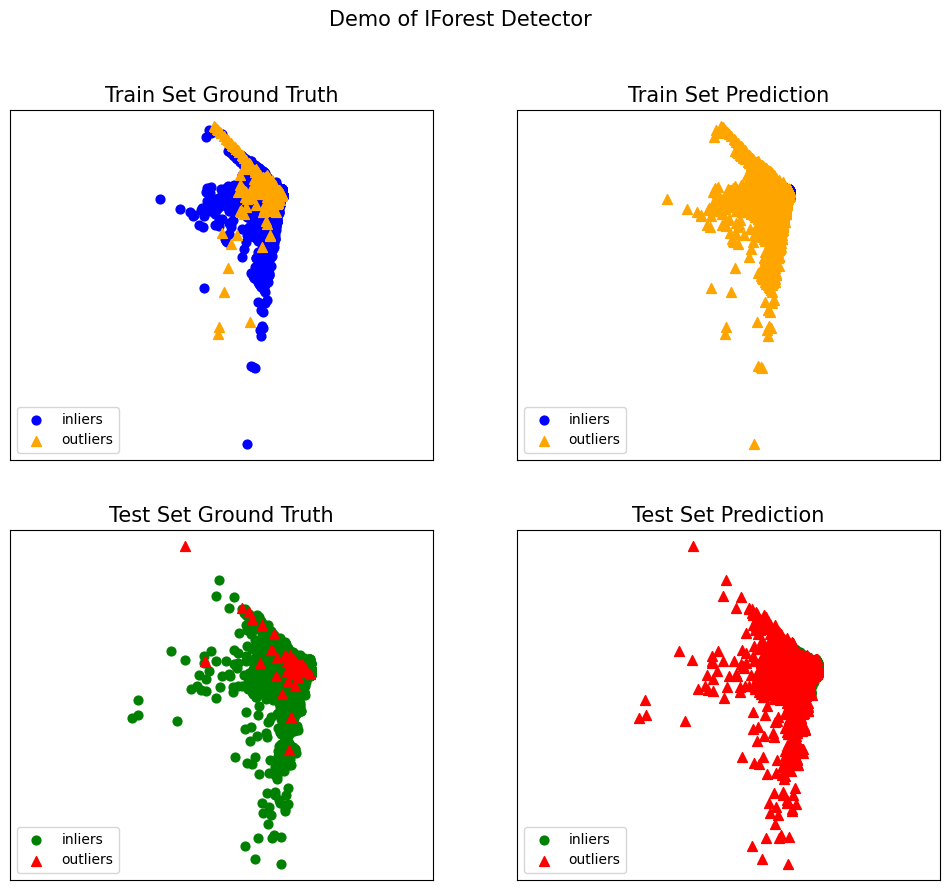

In [27]:
# visualize the results
X_train_2 = X_train[:, top2]
X_test_2 = X_test[:, top2]
visualize(clf_name, X_train_2, y_train, X_test_2, y_test, y_train_pred,
            y_test_pred, show_figure=True, save_figure=True)

ECOD

In [29]:
clf_name = 'ECOD'
clf = ECOD()
clf.fit(X_train)

ECOD(contamination=0.1, n_jobs=1)

In [30]:
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)




On Training Data:
ECOD ROC:0.9437, precision @ rank n:0.3005

On Test Data:
ECOD ROC:0.9796, precision @ rank n:0.2553


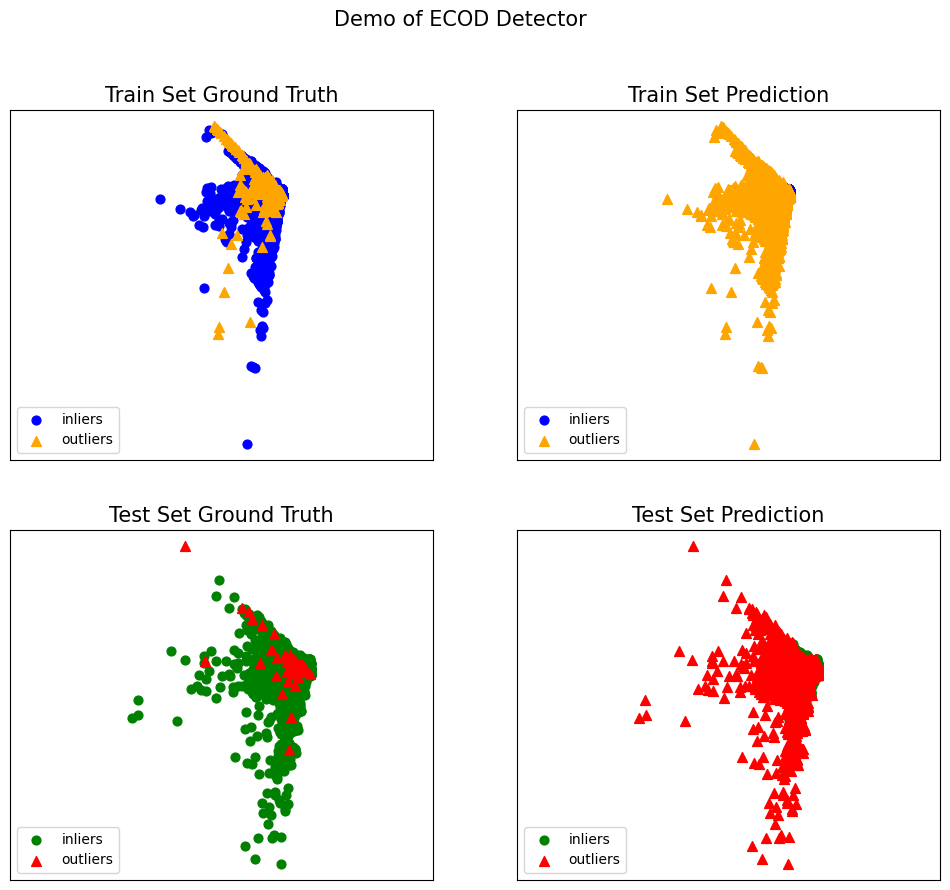

In [31]:
# visualize the results
X_train_2 = X_train[:, top2]
X_test_2 = X_test[:, top2]
visualize(clf_name, X_train_2, y_train, X_test_2, y_test, y_train_pred,
            y_test_pred, show_figure=True, save_figure=True)

In [ ]:
clf_name = 'ABOD'
clf = ABOD()
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)



In [ ]:
# visualize the results
X_train_2 = X_train[:, top2]
X_test_2 = X_test[:, top2]
visualize(clf_name, X_train_2, y_train, X_test_2, y_test, y_train_pred,
            y_test_pred, show_figure=True, save_figure=True)

DevNet

In [ ]:
clf_name = 'DevNet'
clf = DevNet(random_state=42)
clf.fit(X_train, y_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

In [ ]:
# visualize the results
X_train_2 = X_train[:, top2]
X_test_2 = X_test[:, top2]
visualize(clf_name, X_train_2, y_train, X_test_2, y_test, y_train_pred,
            y_test_pred, show_figure=True, save_figure=True)